In [ ]:
import numpy as np
import torch
import pandas as pd
import os
import torchvision
from torchvision import transforms
import datetime
import matplotlib.pyplot as plt


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
'''
#can also download from kaggle
os.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/aps360_dataset'
!kaggle datasets download -d msambare/fer2013
'''

"\nos.environ['KAGGLE_CONFIG_DIR'] = '/content/drive/MyDrive/aps360_dataset'\n!kaggle datasets download -d msambare/fer2013\n"

In [ ]:
#could take 10 minites to import to google drive
#faster if unzip locally to /content
!unzip '/content/drive/MyDrive/aps360_dataset/FER-2013.zip' -d '/content/drive/MyDrive/emotions' #&& rm *.zip

In [ ]:
# the original image size
img_size = 48

In [ ]:
# Composes several transforms together.
data_transform = transforms.Compose(
    [
        #convert image to grayscale
        transforms.Grayscale(num_output_channels=3),
        #randomly adding brightness 
        transforms.ColorJitter(brightness=(1,1.2)),
        #apply ramdom rotation from -30 to 30 degrees
        transforms.RandomRotation(30),
        #apply random horizontal flip with probability of 50% 
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.ToTensor(),
        #normalize the data with 0.5 mean and variance.
        transforms.Normalize((0.5), (0.5), inplace=True)
       
    ])

parent_path = '/content/drive/MyDrive/emotions/FER-2013/'
training_set = torchvision.datasets.ImageFolder(parent_path+'train',transform = data_transform)
valid_set = torchvision.datasets.ImageFolder(parent_path+'valid',transform = data_transform)
test_set = torchvision.datasets.ImageFolder(parent_path+'test',transform = data_transform)

batch_size = 400
# two sub processes used for data loading
num_workers = 1

#get data loader
train_loader = torch.utils.data.DataLoader(training_set,batch_size = batch_size ,num_workers = num_workers,shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_set,batch_size = batch_size ,num_workers = num_workers,shuffle = True)
test_loader = torch.utils.data.DataLoader(test_set,batch_size = batch_size,num_workers = num_workers,shuffle = True)


<class 'torch.Tensor'>
torch.Size([3, 48, 48])


(3, 48, 48)


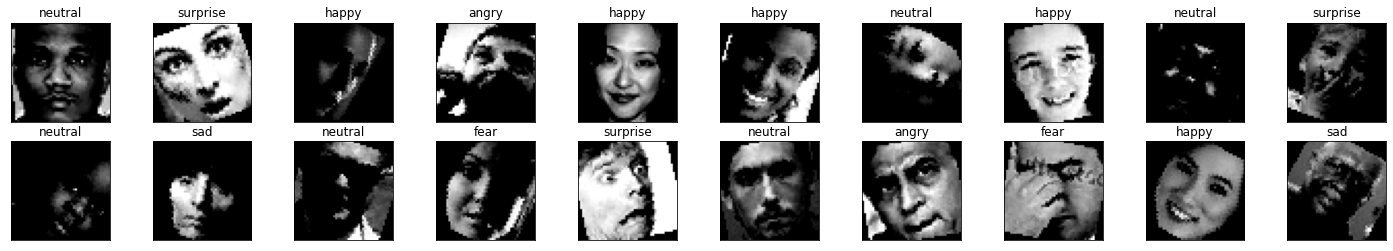

In [ ]:
#we plot of images for verification
data_iter = iter(train_loader)
images, labels = data_iter.next()
images = images.numpy()
print(images[2].shape)
classes = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    
    img = np.transpose(images[idx], (1, 2, 0))
    #to disable the clip warning when ploting
    img = img/np.amax(img)
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    ax.set_title(classes[labels[idx]])


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt # for plotting
import torch.optim as optim
class Baseline(nn.Module):
    def __init__(self):
        super(Baseline, self).__init__()
        self.name="Baseline"
        self.layer1 = nn.Linear(3* 48 * 48, 4096)
        self.layer2 = nn.Linear(4096, 200)
        self.layer3 = nn.Linear(200, 7)
    def forward(self, img):
        flattened = img.view(-1, 3* 48 * 48)
        activation1 = self.layer1(flattened)
        activation1 = F.relu(activation1)
        activation2 = self.layer2(activation1)
        activation2 = F.relu(activation2)
        activation3 = self.layer3(activation2)
        return activation3

In [ ]:
net = Baseline()

In [ ]:
location = '/content/drive/MyDrive/data_tensor'
train_data = torchvision.datasets.DatasetFolder(location + '/train', loader=torch.load, extensions=('.tensor'))
val_data = torchvision.datasets.DatasetFolder(location + '/val', loader=torch.load, extensions=('.tensor'))

In [ ]:
print(len(val_data))

3589


In [ ]:
def get_accuracy(model, data):
    correct = 0
    total = 0
    for imgs, labels in data:
        imgs.cuda()
        labels.cuda()
        output = model(imgs)
        
        #select index with maximum prediction score
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

In [ ]:
def train_net(net, batch_size=64, learning_rate=0.001, num_epochs=30):
    torch.manual_seed(1000)
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                               shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size,
                                               shuffle=True)
    # Define the Loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    k = 1
    
    for epoch in range(num_epochs):
        for imgs, labels in train_loader:
            
           
            
            out = net(imgs)             # forward pass
            
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch
           
            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            
            n += 1
            
        k+=1
        tr = get_accuracy(net, train_loader)
        vr = get_accuracy(net, val_loader)
        train_acc.append(tr) # compute training accuracy 
        val_acc.append(vr)  # compute validation accuracy
        
        print(("Epoch {}: Training Accuracy: {} Validation Accuracy: {}").format(epoch + 1,
                                                                                 train_acc[-1],
                                                                                 val_acc[-1]))
    # Save the current model (checkpoint) to a file
    model_path = "model_{0}_bs{1}_lr{2}_num_epochs{3}".format(net.name,
                                                         batch_size,
                                                         learning_rate,
                                                         num_epochs)
    torch.save(net.state_dict(), model_path)
    # plotting
    plt.title("Training Curve")
    plt.plot(iters, losses, label="Train")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Training Curve")
    plt.plot(range(1, k), train_acc, label="Train")
    plt.plot(range(1,k), val_acc, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]))
    print("Final Validation Accuracy: {}".format(val_acc[-1]))

In [ ]:
torch.cuda.get_device_properties('cuda:0')

_CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)

Epoch 1: Training Accuracy: 0.2558779476819116 Validation Accuracy: 0.24853719699080523
Epoch 2: Training Accuracy: 0.2715873071162353 Validation Accuracy: 0.2663694622457509
Epoch 3: Training Accuracy: 0.27740429830366786 Validation Accuracy: 0.27249930342713846
Epoch 4: Training Accuracy: 0.28558988470514474 Validation Accuracy: 0.28141543605461133
Epoch 5: Training Accuracy: 0.29635306001602285 Validation Accuracy: 0.29005293953747563
Epoch 6: Training Accuracy: 0.30338918109303703 Validation Accuracy: 0.2984118138757314
Epoch 7: Training Accuracy: 0.3106342958654081 Validation Accuracy: 0.3037057676232934
Epoch 8: Training Accuracy: 0.3133860461876067 Validation Accuracy: 0.30509891334633604
Epoch 9: Training Accuracy: 0.32453237660663903 Validation Accuracy: 0.3165227082752856
Epoch 10: Training Accuracy: 0.32550768051830437 Validation Accuracy: 0.320980774589022
Epoch 11: Training Accuracy: 0.332578633877878 Validation Accuracy: 0.320980774589022
Epoch 12: Training Accuracy: 0.33

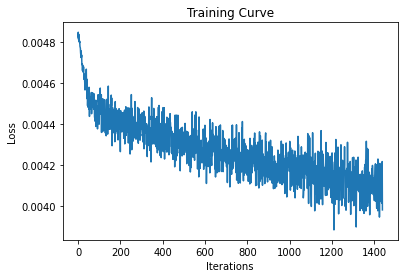

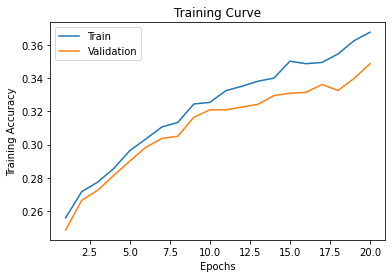

Final Training Accuracy: 0.3678289038280679
Final Validation Accuracy: 0.3488436890498746


In [ ]:
net = Baseline()
train_net(net, batch_size=400, num_epochs=20, learning_rate=0.001)

Epoch 1: Training Accuracy: 0.31052979901772965 Validation Accuracy: 0.30844246308163836
Epoch 2: Training Accuracy: 0.3491588003761886 Validation Accuracy: 0.33463360267483977
Epoch 3: Training Accuracy: 0.3697098470862796 Validation Accuracy: 0.34466425188074673
Epoch 4: Training Accuracy: 0.3826674561984047 Validation Accuracy: 0.3563666759543048
Epoch 5: Training Accuracy: 0.41596711832526384 Validation Accuracy: 0.36862635831707996
Epoch 6: Training Accuracy: 0.42781009439548573 Validation Accuracy: 0.369183616606297
Epoch 7: Training Accuracy: 0.4586366644606221 Validation Accuracy: 0.3725271663415993
Epoch 8: Training Accuracy: 0.4722212546588178 Validation Accuracy: 0.3786570075229869
Epoch 9: Training Accuracy: 0.49468807690967986 Validation Accuracy: 0.38005015324602953
Epoch 10: Training Accuracy: 0.5113727402556689 Validation Accuracy: 0.37614934522151017
Epoch 11: Training Accuracy: 0.5512905360688286 Validation Accuracy: 0.3636110337141265
Epoch 12: Training Accuracy: 0.5

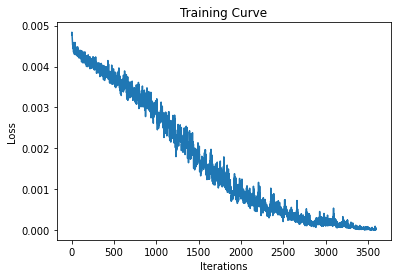

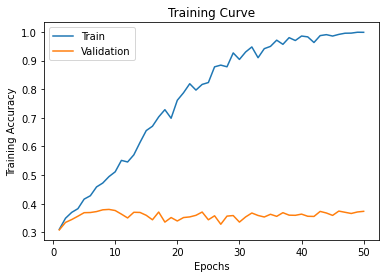

Final Training Accuracy: 0.9986415409801804
Final Validation Accuracy: 0.3733630537754249


In [ ]:

train_net(net, batch_size=400, num_epochs=50, learning_rate=0.01)